In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import get_levels, load_dict, save_dict
from src.models import GaussianMean
from src.gmutils import *

# PLOT PREAMBLE: LIKE LATEX
LATEX_WIDTH = 2.8
LATEX_HEIGHT = 3.24

SCRIPT_SIZE = 7

#Direct input
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : SCRIPT_SIZE,
          'axes.labelsize' : SCRIPT_SIZE,
          'xtick.labelsize' : SCRIPT_SIZE,
          'ytick.labelsize' : SCRIPT_SIZE,
          'legend.fontsize' : SCRIPT_SIZE,
          'figure.titlesize' : SCRIPT_SIZE,
          'font.family' : 'serif',
          'font.serif': ['Computer Modern Roman']
          }
plt.rcParams.update(params)

ModuleNotFoundError: No module named 'src'

In [9]:
def get_densities(mode, method, position='upper_right'):
    """Computes all densities of interest for a given setting.
    mode = {'skewed_prior', 'skewed_like'}
    method = {'inner', 'outer'}
    """
    # Centered prior
    n, d = 1, 2
    mu_0 = np.zeros(d)

    # Covariance matrices
    Sigma_0, Sigma = load_covariances(mode)

    # Get covariance of gibbs marginal
    Sigma_G = get_gibbs_prior_covariance(Sigma_0, Sigma, n, method=method)

    # Load observations
    y_obs = load_dict('../data/y_obs.p')

    # Initialize models
    model = GaussianMean(mu_0=mu_0, Sigma_0=Sigma_0, Sigma=Sigma, n_observ=n, test_model=False)
    model_gibbs = GaussianMean(mu_0=mu_0, Sigma_0=Sigma_G, Sigma=Sigma, n_observ=n, test_model=False)

    # Get densities of interest
    densities = {}
    densities['prior'] = model.get_prior_density()
    densities['posterior'] = model.get_posterior_density(y=y_obs[0])
    densities['approx'] = model.get_exact_ADVI_mf_density(y=y_obs[0], method=method)
    densities['gibbs_prior'] = model_gibbs.get_prior_density()
    densities['gibbs_posterior'] = model_gibbs.get_posterior_density(y=y_obs[0])
    densities['get_eap'] = lambda y: model.get_exact_approximation_prior(y=y, method=method)
    return densities

def sns_plot_density(ax, X, Y, Z, color, alpha, linestyles, linewidths, label=None):
    p_min = get_levels(Z, 1)[0]
    sns.kdeplot(x=X[np.where(Z >= p_min)], y=Y[np.where(Z >= p_min)], color=color, alpha=alpha, fill=True, levels=2, ax=ax)
    sns.kdeplot(x=X[np.where(Z >= p_min)], y=Y[np.where(Z >= p_min)], color=color, linestyles=linestyles,
                linewidths=linewidths,
                levels=2,
                label=label,
                ax=ax)
    return

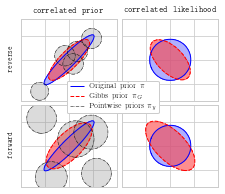

In [10]:
# Hyperparameters
xlims = [-2, 2]
ylims = [-1.7, 1.7]
n_steps = 200
save_path = '../fig/example_priors.pdf'
colors = {'prior' : 'blue', 'gibbs_prior' : 'red', 'pi_y' : 'black'}
alphas = {'prior' : .6, 'gibbs_prior' : .6, 'pi_y' : .3}
linestyles = {'prior' : '-', 'gibbs_prior' : '--', 'pi_y' : '-.'}
linewidths = {'prior' : 1, 'gibbs_prior' : 1, 'pi_y' : .5}
labels = {'prior' : r'Original prior $\pi$', 'gibbs_prior' : r'Gibbs prior $\pi_G$',
          'pi_y' : r'Pointwise priors $\pi_y$'}
modes = ['skewed_prior', 'skewed_like']
methods = ['inner', 'outer']

# Hand-crafted points for pi_y
y_obs = load_dict('../data/y_obs.p')

fig, axs = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(LATEX_WIDTH, .85*LATEX_WIDTH)
plt.subplots_adjust(top = .99, bottom=.01, left=.01, right=.99, hspace=.05, wspace=.05)


# Make plots

x = np.linspace(*xlims, n_steps)
y = np.linspace(*ylims, n_steps)
X, Y = np.meshgrid(x, y)

for i in range(2):
    for j in range(2):
        # Get setting for subfigure
        ax = axs[i, j]
        method = methods[i]
        mode = modes[j]

        densities = get_densities(mode=mode, method=method)

        # Plot densities
        for density_type in ['prior', 'gibbs_prior']:
            density = densities[density_type]
            Z = grid_eval_fn(density, X, Y)
            # ax.contourf(X, Y, Z, levels=get_levels(Z, 1, upper_bound=True),
            #             colors=colors[density_type], alpha=alphas[density_type])
            label = None
            if i == 0 and j == 0:
                label = labels[density_type]
            sns_plot_density(ax=ax, X=X, Y=Y, Z=Z, color=colors[density_type], alpha=alphas[density_type],
                             linestyles=linestyles[density_type], linewidths=linewidths[density_type], label=label)
        # Plot pi_y only for skewed_prior
        if mode == 'skewed_prior':
            density_type = 'pi_y'
            for k in range(y_obs.shape[0]):
                density = densities['get_eap'](y_obs[k])
                Z = grid_eval_fn(density, X, Y)
                # ax.contourf(X, Y, Z, levels=get_levels(Z, 1, upper_bound=True),
                #             colors=colors['pi_y'], alpha=alphas['pi_y'])
                # sns.kdeplot(X, Y, Z, levels=get_levels(Z, 1, upper_bound=True),
                #             colors=colors['pi_y'], alpha=alphas['pi_y'])
                label = None
                if i == 0 and j == 0 and k == 0:
                    label = labels[density_type]
                sns_plot_density(ax=ax, X=X, Y=Y, Z=Z, color=colors[density_type], alpha=alphas[density_type],
                             linestyles=linestyles[density_type], linewidths=linewidths[density_type], label=label)

        # Set lims
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)

        # Ticks
        ax.set_xticks([-2, -1, 0, 1, 2])
        ax.set_yticks([-1, 0, 1])

        ax.set_xticklabels([])
        ax.set_yticklabels([])

# Legend
# legend_elements = [Line2D([0], [0], color=colors['prior'],
#                                       lw=2, label=r'Original prior $\pi$'),
#                                Line2D([0], [0], color=colors['gibbs_prior'],
#                                       lw=2, label=r'Gibbs prior $\pi_G$'),
#                                Line2D([0], [0], color=colors['pi_y'],
#                                       lw=2, label=r'Pointwise priors $\pi_y$')]
# fig.legend(handles=legend_elements, loc='center', framealpha=1, frameon=True)
fig.legend(loc='center', framealpha=1, frameon=True)

# Set row and column titles
row_titles = [r'\texttt{reverse}', r'\texttt{forward}']
col_titles = [r'\texttt{correlated prior}', r'\texttt{correlated likelihood}']
for ax, col in zip(axs[0], col_titles):
    ax.set_title(col)
for ax, row in zip(axs[:,0], row_titles):
    ax.set_ylabel(row, rotation=90)


if save_path is not None:
    plt.savefig(fname=save_path, bbox_inches='tight')

# tikzplotlib.save('../fig/example_priors.tex')

plt.show()

### Prior plots
Note that $$\pi_y$$ is improper for skewed_like. It is therefore only plotted for skewed_prior

### Posterior plots

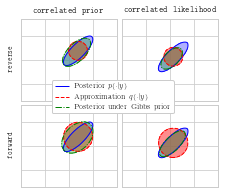

In [4]:
# Hyperparameters
# xlims = [-1, 1.5]
# ylims = [-1, 1.5]
xlims = [-2, 2]
ylims = [-1.7, 1.7]
n_steps = 200
save_path = '../fig/example_posteriors.pdf'
colors = {'posterior' : 'blue', 'approx' : 'red', 'gibbs_posterior' : 'green'}
alphas = {'posterior' : .6, 'approx' : .6, 'gibbs_posterior' : .3}
linestyles = {'posterior' : '-', 'approx' : '--', 'gibbs_posterior' : '-.'}
linewidths = {'posterior' : 1, 'approx' : 1, 'gibbs_posterior' : 1}
labels = {'posterior' : r'Posterior $p(\cdot|y)$',
          'approx' : r'Approximation $q(\cdot|y)$',
          'gibbs_posterior' : r'Posterior under Gibbs prior'}
modes = ['skewed_prior', 'skewed_like']
methods = ['inner', 'outer']

# Hand-crafted points for pi_y
y_obs = load_dict('../data/y_obs.p')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(linewidth, .85*linewidth))
fig.set_size_inches(LATEX_WIDTH, .85*LATEX_WIDTH)
plt.subplots_adjust(top = .99, bottom=.01, left=.01, right=.99, hspace=.05, wspace=.05)

# Make plots

x = np.linspace(*xlims, n_steps)
y = np.linspace(*ylims, n_steps)
X, Y = np.meshgrid(x, y)

for i in range(2):
    for j in range(2):
        # Get setting for subfigure
        ax = axs[i, j]
        method = methods[i]
        mode = modes[j]

        densities = get_densities(mode=mode, method=method)

        # Plot densities
        for density_type in ['posterior', 'approx', 'gibbs_posterior']:
            density = densities[density_type]
            Z = grid_eval_fn(density, X, Y)
            # ax.contourf(X, Y, Z, levels=get_levels(Z, 1, upper_bound=True),
            #             colors=colors[density_type], alpha=alphas[density_type])
            label = None
            if i == 0 and j == 0:
                label = labels[density_type]
            sns_plot_density(ax=ax, X=X, Y=Y, Z=Z, color=colors[density_type], alpha=alphas[density_type],
                             linestyles=linestyles[density_type], linewidths=linewidths[density_type], label=label)

        # Set lims
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)

        # Ticks
        ax.set_xticks([-2, -1, 0, 1, 2])
        ax.set_yticks([-1, 0, 1])

        ax.set_xticklabels([])
        ax.set_yticklabels([])

# Legend
# legend_elements = [Line2D([0], [0], color=colors['posterior'],
#                           lw=2, label=r'Posterior $p(\cdot|y)$'),
#                    Line2D([0], [0], color=colors['approx'],
#                           lw=2, label=r'Approximation $q(\cdot|y)$'),
#                    Line2D([0], [0], color=colors['gibbs_posterior'],
#                           lw=2, label=r'Posterior under Gibbs prior')]
# fig.legend(handles=legend_elements, loc='center', framealpha=1, frameon=True)
fig.legend(loc='center', framealpha=1, frameon=True)
# fig.legend()

# Set row and column titles
row_titles = [r'\texttt{reverse}', r'\texttt{forward}']
col_titles = [r'\texttt{correlated prior}', r'\texttt{correlated likelihood}']
for ax, col in zip(axs[0], col_titles):
    ax.set_title(col)
for ax, row in zip(axs[:,0], row_titles):
    ax.set_ylabel(row, rotation=90)


if save_path is not None:
    plt.savefig(fname=save_path, bbox_inches='tight')

# tikzplotlib.save('../fig/example_posteriors.tex')

plt.show()